In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [85]:
from google.colab import files
files.upload()

Saving ratings_user-item.csv to ratings_user-item.csv


{'ratings_user-item.csv': b'userId,movieId,rating\r\n1,1,4\r\n1,3,4\r\n1,6,4\r\n1,47,5\r\n1,50,5\r\n1,70,3\r\n1,101,5\r\n1,110,4\r\n1,151,5\r\n1,157,5\r\n1,163,5\r\n1,216,5\r\n1,223,3\r\n1,231,5\r\n1,235,4\r\n1,260,5\r\n1,296,3\r\n1,316,3\r\n1,333,5\r\n1,349,4\r\n1,356,4\r\n1,362,5\r\n1,367,4\r\n1,423,3\r\n1,441,4\r\n1,457,5\r\n1,480,4\r\n1,500,3\r\n1,527,5\r\n1,543,4\r\n1,552,4\r\n1,553,5\r\n1,590,4\r\n1,592,4\r\n1,593,4\r\n1,596,5\r\n1,608,5\r\n1,648,3\r\n1,661,5\r\n1,673,3\r\n1,733,4\r\n1,736,3\r\n1,780,3\r\n1,804,4\r\n1,919,5\r\n1,923,5\r\n1,940,5\r\n1,943,4\r\n1,954,5\r\n1,1009,3\r\n1,1023,5\r\n1,1024,5\r\n1,1025,5\r\n1,1029,5\r\n1,1030,3\r\n1,1031,5\r\n1,1032,5\r\n1,1042,4\r\n1,1049,5\r\n1,1060,4\r\n1,1073,5\r\n1,1080,5\r\n1,1089,5\r\n1,1090,4\r\n1,1092,5\r\n1,1097,5\r\n1,1127,4\r\n1,1136,5\r\n1,1196,5\r\n1,1197,5\r\n1,1198,5\r\n1,1206,5\r\n1,1208,4\r\n1,1210,5\r\n1,1213,5\r\n1,1214,4\r\n1,1219,2\r\n1,1220,5\r\n1,1222,5\r\n1,1224,5\r\n1,1226,5\r\n1,1240,5\r\n1,1256,5\r\n1,1258,3\

In [0]:
#DATASET LINKS
### https://www.kaggle.com/ranja7/movieratingsbyusers
### https://www.kaggle.com/rounakbanik/pokemon


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

#### Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import col, isnan, count, when

from pyspark.ml.clustering import KMeans
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.classification import LabeledPoint, LogisticRegressionWithLBFGS

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

#### Configuration

In [0]:
conf = SparkConf().setAppName('App').setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [13]:
# Loading Data from CSV file. Pokemon Data
dataset = spark.read.csv("pokemon.csv", header=True, inferSchema=True)
dataset.show(7)

+--------------------+-----------+------------+--------------+----------------+-------------+-------------+------------+--------------+-------------+-------------+--------------+-----------+--------------+--------------+---------------+------------+-------------+-------------+------+--------------+--------------+----------+------------+-------------------+-------+-----------------+--------+---+---------------------+----------+---------------+--------------+---------+----------+-----+-----+------+---------+----------+------------+
|           abilities|against_bug|against_dark|against_dragon|against_electric|against_fairy|against_fight|against_fire|against_flying|against_ghost|against_grass|against_ground|against_ice|against_normal|against_poison|against_psychic|against_rock|against_steel|against_water|attack|base_egg_steps|base_happiness|base_total|capture_rate|      classfication|defense|experience_growth|height_m| hp|        japanese_name|      name|percentage_male|pokedex_number|sp_

### Exploratory Data Analysis

In [14]:
# Rows & Columns of Data
print ("Rows:", dataset.count())
print ("Columns:", len(dataset.columns))

Rows: 801
Columns: 41


In [15]:
# Null Values
dataset.select([count(when(col(cl).isNull() | isnan(cl), cl)).alias(cl) for cl in dataset.columns]).show()

+---------+-----------+------------+--------------+----------------+-------------+-------------+------------+--------------+-------------+-------------+--------------+-----------+--------------+--------------+---------------+------------+-------------+-------------+------+--------------+--------------+----------+------------+-------------+-------+-----------------+--------+---+-------------+----+---------------+--------------+---------+----------+-----+-----+-----+---------+----------+------------+
|abilities|against_bug|against_dark|against_dragon|against_electric|against_fairy|against_fight|against_fire|against_flying|against_ghost|against_grass|against_ground|against_ice|against_normal|against_poison|against_psychic|against_rock|against_steel|against_water|attack|base_egg_steps|base_happiness|base_total|capture_rate|classfication|defense|experience_growth|height_m| hp|japanese_name|name|percentage_male|pokedex_number|sp_attack|sp_defense|speed|type1|type2|weight_kg|generation|is_leg

In [0]:
# Pandas Dataframe
df = dataset.toPandas()

(array([  2.,   9.,  42., 166., 148., 191.,  90.,  91.,  32.,  11.,   7.,
          4.,   2.,   1.,   1.,   0.,   1.,   1.,   0.,   2.]),
 array([  1. ,  13.7,  26.4,  39.1,  51.8,  64.5,  77.2,  89.9, 102.6,
        115.3, 128. , 140.7, 153.4, 166.1, 178.8, 191.5, 204.2, 216.9,
        229.6, 242.3, 255. ]),
 <a list of 20 Patch objects>)

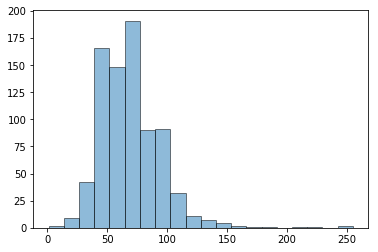

In [21]:
# hp: The Base HP of the Pokemon
plt.hist(df["hp"], bins=20, edgecolor="black", alpha=0.5)

(array([  7.,   5.,  55., 104., 156., 128.,  90.,  75.,  80.,  29.,  28.,
         20.,  13.,   3.,   1.,   3.,   0.,   1.,   0.,   3.]),
 array([  5.  ,  16.25,  27.5 ,  38.75,  50.  ,  61.25,  72.5 ,  83.75,
         95.  , 106.25, 117.5 , 128.75, 140.  , 151.25, 162.5 , 173.75,
        185.  , 196.25, 207.5 , 218.75, 230.  ]),
 <a list of 20 Patch objects>)

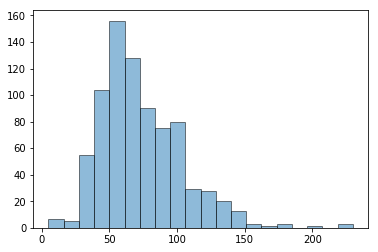

In [29]:
# "defense: The Base Defense of the Pokemon"
plt.hist(df["defense"], bins=20, edgecolor="black", alpha=0.5)

(array([ 5.,  1.,  9., 10., 25., 43., 34., 58., 53., 57., 82., 51., 50.,
        44., 42., 68., 30., 22., 14., 28., 25., 11.,  9.,  6.,  8.,  7.,
         4.,  1.,  0.,  4.]),
 array([  5.,  11.,  17.,  23.,  29.,  35.,  41.,  47.,  53.,  59.,  65.,
         71.,  77.,  83.,  89.,  95., 101., 107., 113., 119., 125., 131.,
        137., 143., 149., 155., 161., 167., 173., 179., 185.]),
 <a list of 30 Patch objects>)

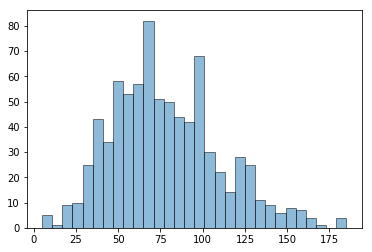

In [23]:
# "attack: The Base Attack of the Pokemon"
plt.hist(df["attack"], bins=30, edgecolor="black", alpha=0.5)

In [32]:
# Classes & their Counts
classes, counts = np.unique(np.array(df["is_legendary"]), return_counts=True)
print(classes, counts)

[0 1] [731  70]


<BarContainer object of 2 artists>

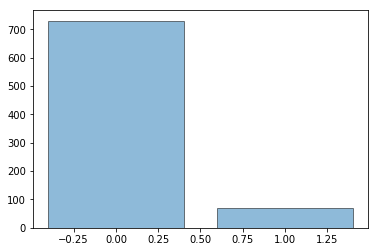

In [31]:
# Balanced Class
plt.bar(range(len(counts)), counts, edgecolor="black", alpha=0.5)

### Recommender System
##### Collaborative filtering using Alternative Least Squares Method

In [87]:
# Loading Data
dataset = spark.read.csv("ratings_user-item.csv", header=True)
dataset.show(10)
dataset.count()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|     4|
|     1|      3|     4|
|     1|      6|     4|
|     1|     47|     5|
|     1|     50|     5|
|     1|     70|     3|
|     1|    101|     5|
|     1|    110|     4|
|     1|    151|     5|
|     1|    157|     5|
+------+-------+------+
only showing top 10 rows



100836

In [89]:
# NOTE: This Cell sometimes gives an error, so run it once again and it will run without error..

# Train & Test Data
df = dataset.toPandas()
train = []
test = []
for idx, row in df.iterrows():
    train.append((row["userId"], row["movieId"], row["rating"]))
    test.append((row["userId"], row["movieId"]))
    

# Training Model
rdd_train = sc.parallelize(train)
model = ALS.train(rdd_train, 1, seed=50)

# Testing Model
rdd_test = sc.parallelize(test)
test_preds = model.predictAll(rdd_test)

test_preds = spark.createDataFrame(test_preds)
test_preds.createOrReplaceTempView("Prediction")
test_preds = test_preds.toPandas()
test_ratings = test_preds["rating"]
test_ratings = list(test_ratings)

# Evaluating Model with Mean Square Error
error = 0.0
for x in range(len(test_ratings)):
    error += (test_ratings[x] - float(train[x][2])) ** 2
error /= len(test_ratings)

print("Mean Square Error(MSE) =", error)

Mean Square Error(MSE) = 3.721352324793333


### Classification
##### Logistic regression using LogisticRegressionWithLBFGS Method

In [33]:
# Loading Data
dataset = spark.read.csv("pokemon.csv", header=True, inferSchema=True)
dataset.show(5)

+--------------------+-----------+------------+--------------+----------------+-------------+-------------+------------+--------------+-------------+-------------+--------------+-----------+--------------+--------------+---------------+------------+-------------+-------------+------+--------------+--------------+----------+------------+--------------+-------+-----------------+--------+---+---------------------+----------+---------------+--------------+---------+----------+-----+-----+------+---------+----------+------------+
|           abilities|against_bug|against_dark|against_dragon|against_electric|against_fairy|against_fight|against_fire|against_flying|against_ghost|against_grass|against_ground|against_ice|against_normal|against_poison|against_psychic|against_rock|against_steel|against_water|attack|base_egg_steps|base_happiness|base_total|capture_rate| classfication|defense|experience_growth|height_m| hp|        japanese_name|      name|percentage_male|pokedex_number|sp_attack|sp_

In [0]:
# Train & Test Data
df = dataset.toPandas()
train = []
test = []
for i, row in df.iterrows():
    feats = [row["hp"], row["attack"], row["defense"], row["generation"]]
    target_label = row["is_legendary"]

    train.append(LabeledPoint(target_label, feats))
    test.append(feats)

In [37]:
# Training
rdd_train = sc.parallelize(train)
model = LogisticRegressionWithLBFGS.train(rdd_train, iterations=10, numClasses=len(counts))

# Testing/Predicting
rdd_test = sc.parallelize(test)
test_preds = model.predict(rdd_test)
test_preds = test_preds.map(lambda x: x).collect()

# Evaluating Model with Accuracy
x = 0
for x in range(len(train)):
    if int(test_preds[x]) == int(train[x].label):
        x += 1
print("Accuracy =", (x / len(train)))

Accuracy = 0.9987515605493134


['abilities',
 'against_bug',
 'against_dark',
 'against_dragon',
 'against_electric',
 'against_fairy',
 'against_fight',
 'against_fire',
 'against_flying',
 'against_ghost',
 'against_grass',
 'against_ground',
 'against_ice',
 'against_normal',
 'against_poison',
 'against_psychic',
 'against_rock',
 'against_steel',
 'against_water',
 'attack',
 'base_egg_steps',
 'base_happiness',
 'base_total',
 'capture_rate',
 'defense',
 'experience_growth',
 'height_m',
 'hp',
 'percentage_male',
 'pokedex_number',
 'sp_attack',
 'sp_defense',
 'speed',
 'weight_kg',
 'generation',
 'is_legendary']

### Clustering
##### K-Means Clustering

In [78]:
select_cols = ["hp","defense","attack", "base_happiness"]
vec_ass = VectorAssembler(inputCols=select_cols, outputCol="features").transform(dataset)
# vec_ass.show()
# Training
model = KMeans(k=len(classes), seed=50).fit(vec_ass.select('features'))

# Testing
test_preds = model.transform(vec_ass)

# Evaluating Model with ClusteringEvaluator
print("Accuracy =", ClusteringEvaluator(predictionCol="prediction").evaluate(test_preds))

Accuracy = 0.4863630787306543


In [0]:
sc.stop()